In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from underthesea import word_tokenize
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification
from torch.nn import CrossEntropyLoss
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_recall_fscore_support

In [3]:
df = pd.read_csv("vietnamese_sentiment.csv")
df.head(10)

,Id,Emotion,Sentence
0,1,Other,"tính tao tao biết , chẳng có chuyện gì có thể ..."
1,2,Enjoyment,"lại là lào cai , tự hào quê mình quá :))"
2,3,Sadness,bị từ chối rồi
3,4,Enjoyment,tam đảo trời đẹp các mem à
4,5,Other,đọc bình luận của thằng đó không thiếu chữ nào 😂😂
5,6,Enjoyment,crush tao vẫn còn trinh nhé 😘
6,7,Anger,nó nói không đúg ư . đg của nhà bà ư . nó đóg ...
7,8,Fear,gap kiểu này chắc đái ra quần quá
8,9,Enjoyment,yêu em mọa mọa 😘😘
9,10,Sadness,có ai như tao không đọc đề thì quen nhưng lại ...


## EDA

In [4]:
# Shows number of nans
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6927 entries, 0 to 6926
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6927 non-null   int64 
 1   Emotion   6927 non-null   object
 2   Sentence  6927 non-null   object
dtypes: int64(1), object(2)
memory usage: 162.5+ KB


In [5]:
# Find duplicated sentence
dup_sentences = df[df.duplicated(subset=["Sentence"], keep=False)]
dup_sentences.sort_values("Sentence").head(20)

# Drop duplicated sentence
df = df.drop_duplicates(subset=["Sentence"]).reset_index(drop=True)

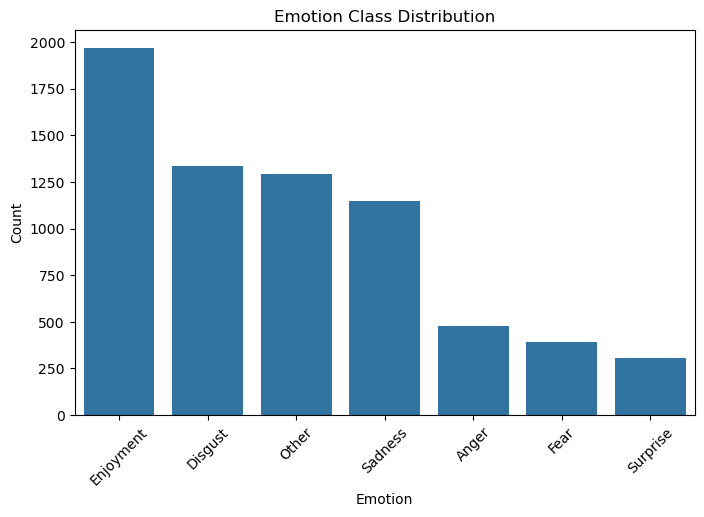

In [6]:
# Label apperance
emotion_counts = df['Emotion'].value_counts()
emotion_counts
plt.figure(figsize=(8,5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.xticks(rotation=45)
plt.title("Emotion Class Distribution")
plt.ylabel("Count")
plt.show()

# Class imbalance is a thing in this dataset. Thus, using Macro-F1 and adding class weights.

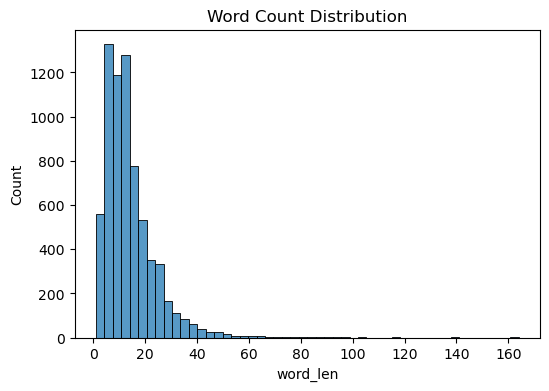

In [7]:
# Word count distribution
df_word = df.copy()
df_word['char_len'] = df_word['Sentence'].str.len()
df_word['word_len'] = df_word['Sentence'].str.split().apply(len)
df_word[['char_len', 'word_len']].describe()
plt.figure(figsize=(6,4))
sns.histplot(df_word['word_len'], bins=50)
plt.title("Word Count Distribution")
plt.show()

# Have some outliers, however, not extreme and happen very few times. Thus, using MAX_LENGTH=128.

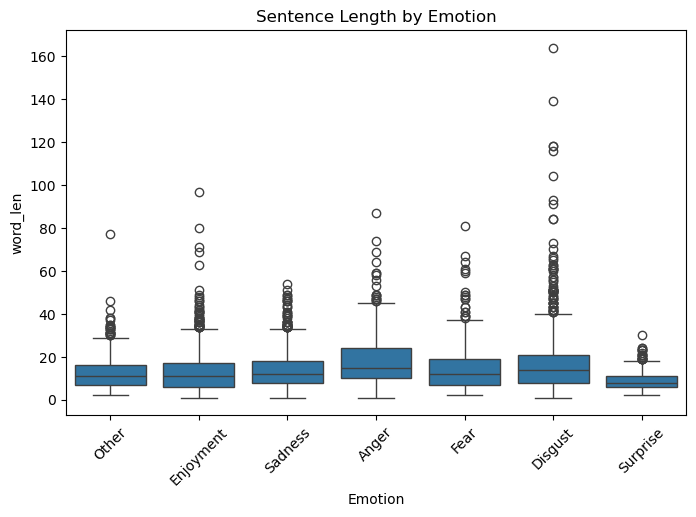

In [8]:
# Sentence length by emotion
plt.figure(figsize=(8,5))
sns.boxplot(x='Emotion', y='word_len', data=df_word)
plt.xticks(rotation=45)
plt.title("Sentence Length by Emotion")
plt.show()

# The model can't assign label based on length.

## Data Processing

In [9]:
RANDOM_STATE = 42

# 1. Split out test first (15%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["Emotion"],
    random_state=RANDOM_STATE
)

# 2. Split train/val from remaining
val_ratio_of_trainval = 0.15 / 0.85

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio_of_trainval,
    stratify=train_val_df["Emotion"],
    random_state=RANDOM_STATE
)

print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Ratios:", len(train_df)/len(df), len(val_df)/len(df), len(test_df)/len(df))

Sizes: 4844 1038 1039
Ratios: 0.6998988585464528 0.14997832683138274 0.15012281462216442


In [10]:
def show_dist(name, data):
    dist = data["Emotion"].value_counts(normalize=True).mul(100).round(2)
    print(f"\n{name} distribution (%)")
    print(dist)

show_dist("FULL", df)
show_dist("TRAIN", train_df)
show_dist("VAL", val_df)
show_dist("TEST", test_df)

# Train/Val/Test set still keeps the distribution like the full dataset.


FULL distribution (%)
Emotion
Enjoyment    28.39
Disgust      19.30
Other        18.64
Sadness      16.60
Anger         6.94
Fear          5.68
Surprise      4.45
Name: proportion, dtype: float64

TRAIN distribution (%)
Emotion
Enjoyment    28.39
Disgust      19.30
Other        18.64
Sadness      16.60
Anger         6.94
Fear          5.68
Surprise      4.46
Name: proportion, dtype: float64

VAL distribution (%)
Emotion
Enjoyment    28.42
Disgust      19.27
Other        18.59
Sadness      16.67
Anger         6.94
Fear          5.68
Surprise      4.43
Name: proportion, dtype: float64

TEST distribution (%)
Emotion
Enjoyment    28.39
Disgust      19.35
Other        18.67
Sadness      16.55
Anger         6.93
Fear          5.68
Surprise      4.43
Name: proportion, dtype: float64


In [11]:
# Text segmentation
def segment_text(text):
    return word_tokenize(text, format="text")

train_df["text"] = train_df["Sentence"].apply(segment_text)
val_df["text"] = val_df["Sentence"].apply(segment_text)
test_df["text"] = test_df["Sentence"].apply(segment_text)

In [12]:
# Label encoding

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["Emotion"])
val_df["label"] = le.transform(val_df["Emotion"])
test_df["label"] = le.transform(test_df["Emotion"])

num_labels = len(le.classes_)

In [13]:
# Tokenizer
MODEL_NAME = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 128

In [14]:
# Dataset wrapper
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
# Handle class imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

## Modeling

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

In [18]:
import torch
print(torch.__version__)

2.5.1+cu121


In [1]:
!pip uninstall torch torchvision torchaudio -y

In [2]:
import torch, transformers
import sys

print("Python:", sys.executable)
print("Torch:", torch.__file__)
print("Transformers:", transformers.__file__)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\GIGABYTE\anaconda3\Lib\site-packages\torch\lib\caffe2_nvrtc.dll" or one of its dependencies.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [21]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [ ]:
# Loss function with class weight
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [ ]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

In [17]:
training_args = TrainingArguments(
    output_dir="./outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=SentimentDataset(train_df["text"].tolist(), train_df["label"].tolist()),
    eval_dataset=SentimentDataset(val_df["text"].tolist(), val_df["label"].tolist()),
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\GIGABYTE\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
test_metrics = trainer.evaluate(
    EmotionDataset(test_df["text"].tolist(), test_df["label"].tolist())
)

print(test_metrics)